# CREACIÓN DE MODELOS DE APRENDIZAJE AUTOMÁTICO A PARTIR DE LOS DATOS OBTENIDOS DE UN VEHÍCULO

# 1. Descripción del problema

A partir de los datos obtenidos mediante el dispositivo desarrollado durante este trabajo se pretenden detectar aquellos comportamientos de los conductores que se puedan calificar como temerarios o anómalos. Estos comportamientos al volante pueden suponen un problema tanto a la seguridad del propio conductor como a los demás usuarios de la vía, además de suponer un problema al propio bienestar del vehículo utilizado, reduciendo posiblemente su vida útil.

Dentro de los datos obtenidos para el vehículo en concreto se dispone de los siguientes:

- EngineCoolantTemp: Temperatura del líquido refrigerante del motor.
- EngineRPM: Revoluciones por minuto a las que gira el motor.
- IntakeAirTemperature: Temperatura del aire que entra al motor.
- IntakeManiAbsPress: Presión de aire en el colector de admisión.
- MAFAirFlowRate: Caudal de aire entrante al motor.
- ThrottlePosition: Posición del acelerador.
- VehicleSpeed: Velocidad del vehículo.

El objetivo del análisis es desarrollar un modelo de clasificación binaria que ayude a predecir si los datos obtenidos se pueden considerar o no temerarios, otorgando de esta forma una puntuación al usuario basada en su comportamiento al volante.

# 2. Obtención y análisis de datos

Los datos obtenidos se encuentran almacenados dentro de la base de datos de series temporales InfluxDB. Mediante el uso de su API HTTP es posible obtener los datos directamente a un fichero CSV.

In [1]:
TOKEN = "7GBNFJXKqzJ7z5ACyPX9fpLbBn1rJaZJhw58596WdWcEX4mU2XdXY_i_stULkKUPQHGdSXS_qCJg0CLcQPNLiw=="

import requests

url = "http://172.16.30.153:8086/api/v2/query?orgID=30a15d55a9e2df4c"
headers = {
    "Accept":"application/csv",
    "Authorization":"Token " + TOKEN,
    "Content-type":"Application/vnd.flux"
}
data = "from (bucket:\"obd2\") |> range (start: -30d)"

x = requests.post(url, data=data, headers = headers)

with open("raw_data.csv", "w") as f:
    f.write(x.text)

Una vez obtenidos estos datos podemos observar la estructura inicial que estos muestran.

```
,result,table,_start,_stop,_time,_value,_field,_measurement,device
,_result,0,2025-08-19T15:06:07.896735202Z,2025-08-26T15:06:07.896735202Z,2025-08-21T18:33:59.08059044Z,30,value,EngineCoolantTemp,esp32can
,_result,0,2025-08-19T15:06:07.896735202Z,2025-08-26T15:06:07.896735202Z,2025-08-21T18:34:04.438120372Z,30,value,EngineCoolantTemp,esp32can
,_result,0,2025-08-19T15:06:07.896735202Z,2025-08-26T15:06:07.896735202Z,2025-08-21T18:34:15.149686887Z,31,value,EngineCoolantTemp,esp32can
```

Se observan varios detalles a primera vista. En primer lugar, todas las líneas empiezan por una coma, lo cual no es ideal a la hora de cargar los datos en Pandas, por lo que habría que eliminarla. Por otra parte, cada línea solo contiene una medición, por lo que es necesario también juntar las diferentes mediciones y colocarlas en un formato tipo tabla.


In [1]:
# Limpieza de las lineas vacías, eliminación de la coma inicial y cabeceras intermedias
with open('raw_data.csv', 'r') as f1, open('clean_raw_data.csv', 'w') as f2:
    for idx, line in enumerate(f1):
        if len(line) > 1:
            output_line = line[1:]
            if idx == 0:
                f2.write(output_line)
            elif output_line[0] == "_":
                f2.write(output_line)

In [2]:
# Eliminación de columnas referentes al tiempo de medición y consulta y dispositivo que realiza la medición
import pandas as pd

df_completo = pd.read_csv('clean_raw_data.csv')
print(df_completo.head)

# Este dataframe solo contiene el tipo de medición y el valor correspondiente
df_data = df_completo[["_measurement","_value"]].copy()

# Se obtiene los distintos tipos de mediciones presentes
measurement_tags = df_data["_measurement"].unique()
print("Mediciones almacenadas: " + str(measurement_tags))

# Se separa cada una de las mediciones y se colocan en formato tabla
series = []

for tag in measurement_tags:
    tmp_df = df_data[df_data["_measurement"] == tag]
    tmp_df = tmp_df.add_prefix(tag)

    tmp_ser = tmp_df.iloc[:,1]
    tmp_ser.reset_index(drop=True, inplace=True)
    series.append(tmp_ser)

# Se almacenan la tabla en un dataframe y en un fichero CSV
df_table = pd.concat(series, join="outer", axis=1, sort=False)
df_table.to_csv('ml_data.csv', index=False)
print(df_table.head())

<bound method NDFrame.head of        result  table                          _start  \
0     _result      0  2025-07-28T13:40:34.200141141Z   
1     _result      0  2025-07-28T13:40:34.200141141Z   
2     _result      0  2025-07-28T13:40:34.200141141Z   
3     _result      0  2025-07-28T13:40:34.200141141Z   
4     _result      0  2025-07-28T13:40:34.200141141Z   
...       ...    ...                             ...   
6968  _result      6  2025-07-28T13:40:34.200141141Z   
6969  _result      6  2025-07-28T13:40:34.200141141Z   
6970  _result      6  2025-07-28T13:40:34.200141141Z   
6971  _result      6  2025-07-28T13:40:34.200141141Z   
6972  _result      6  2025-07-28T13:40:34.200141141Z   

                               _stop                           _time  _value  \
0     2025-08-27T13:40:34.200141141Z   2025-08-21T18:33:59.08059044Z    30.0   
1     2025-08-27T13:40:34.200141141Z  2025-08-21T18:34:04.438120372Z    30.0   
2     2025-08-27T13:40:34.200141141Z  2025-08-21T18:34:15

## 2.1 Análisis inicial del conjunto de datos

Una vez convertidos estos datos a una tabla se puede realizar un análisis de los mismos. Como todos las columnas representan mediciones obtenidas del vehículo, se observa como todos los tipos de datos son de tipo númérico. Se observa también como se cuenta con 1028 entradas de datos, que se corresponde con la información del vehículo en un período de alrededor de hora y media de funcionamiento.

In [3]:
# Información del dataset
print(df_table.info())

# Valores nulos
df_table.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EngineCoolantTemp_value     915 non-null    float64
 1   EngineRPM_value             1025 non-null   float64
 2   IntakeAirTemperature_value  1026 non-null   float64
 3   IntakeManiAbsPress_value    1024 non-null   float64
 4   MAFAirFlowRate_value        929 non-null    float64
 5   ThrottlePosition_value      1028 non-null   float64
 6   VehicleSpeed_value          1026 non-null   float64
dtypes: float64(7)
memory usage: 56.3 KB
None


EngineCoolantTemp_value       113
EngineRPM_value                 3
IntakeAirTemperature_value      2
IntakeManiAbsPress_value        4
MAFAirFlowRate_value           99
ThrottlePosition_value          0
VehicleSpeed_value              2
dtype: int64

Se puede observar como existen entradas dentro del conjunto de datos que presentan valores nulos. Cuando se da esta situación es recomendable eliminar aquellas entradas donde estos aparecen, ya que existen modelos que no son capaces de gestionarlos, sin embargo, tan solo se van a utilizar aquellas características que dependen directamente del usuario, como son la posición del acelerador (ThrottlePosition), la velocidad del vehículo (VehicleSpeed) y las revoluciones del motor (EngineRPM). Por tanto, con la finalidad de maximizar el número de muestras disponibles, ya que características como EngineCoolantTemp cuentan con bastantes valores nulos, primero se eliminarán las características no necesarias para el modelo y posteriormente se realizará la eliminación de los valores nulos.

In [4]:
# Eliminación de características innecesarias
df_ml = df_table.drop(['EngineCoolantTemp_value', 'IntakeAirTemperature_value', 'IntakeManiAbsPress_value', 'MAFAirFlowRate_value'], axis=1).copy()

# Valores nulos
print("Valores nulos dentro de las columnas utilizadas: ")
print(df_ml.isnull().sum())

# Eliminación de valores nulos
df_ml = df_ml.dropna()

print("Valores nulos tras el procesamiento: ")
print(df_ml.isnull().sum())

Valores nulos dentro de las columnas utilizadas: 
EngineRPM_value           3
ThrottlePosition_value    0
VehicleSpeed_value        2
dtype: int64
Valores nulos tras el procesamiento: 
EngineRPM_value           0
ThrottlePosition_value    0
VehicleSpeed_value        0
dtype: int64


## 2.2 Análisis de las características categóricas

Mediante el método describe() de Pandas es posible generar estadísticas que aporten información a acerca de los datos existentes en el conjunto.

In [5]:
df_ml.describe()

,EngineRPM_value,ThrottlePosition_value,VehicleSpeed_value
count,1025.000000,1025.000000,1025.000000
mean,1555.314146,95.026298,42.800976
std,630.746396,4.621959,34.836075
min,0.000000,0.000000,0.000000
25%,819.000000,95.687040,0.000000
50%,1636.000000,95.687040,51.000000
75%,1991.000000,95.687040,67.000000
max,3517.000000,95.687040,129.000000


Se observa como las escalas de los valores son lo suficientemente similares para que esto no suponga un problema para aquellos modelos que tienen en cuenta las distancias para realizar sus predicciones. Se observa además como en los valores de la posición del acelerador se utiliza el rango de forma inversa, indicando que cuanto más cercano a 0 más pulsado está el acelerador.

Mediante el uso de la librería Seaborn es también posible observar como se distribuyen las mediciones, además de que correlación existe entre las distintas características empleadas.

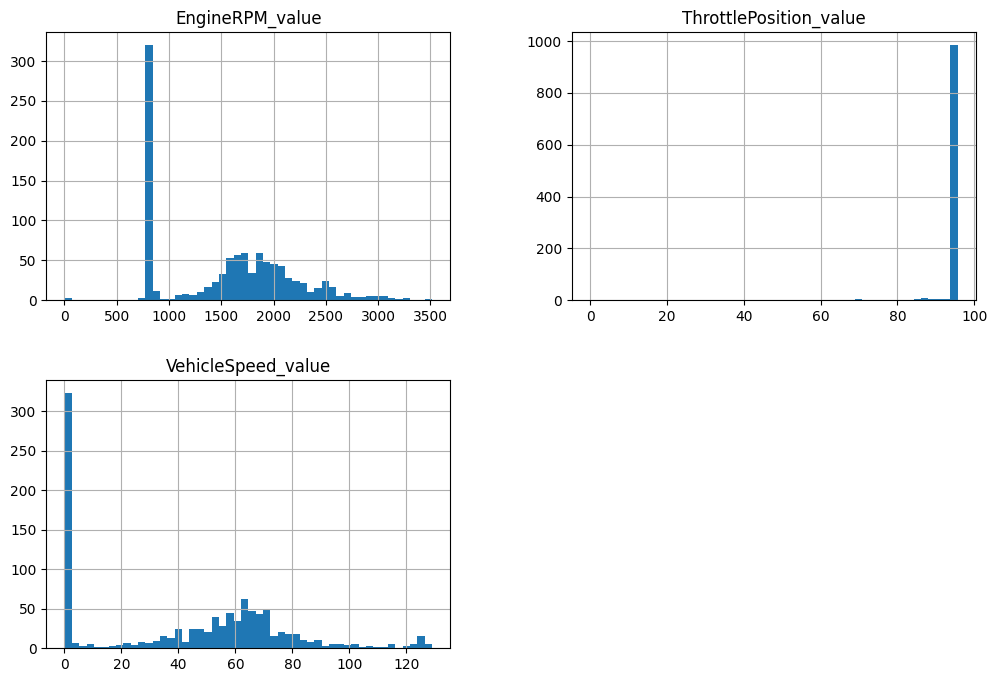

In [6]:
try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# Histograma para todas las variables
df_ml.hist(bins=50, figsize=(12, 8))
plt.show()

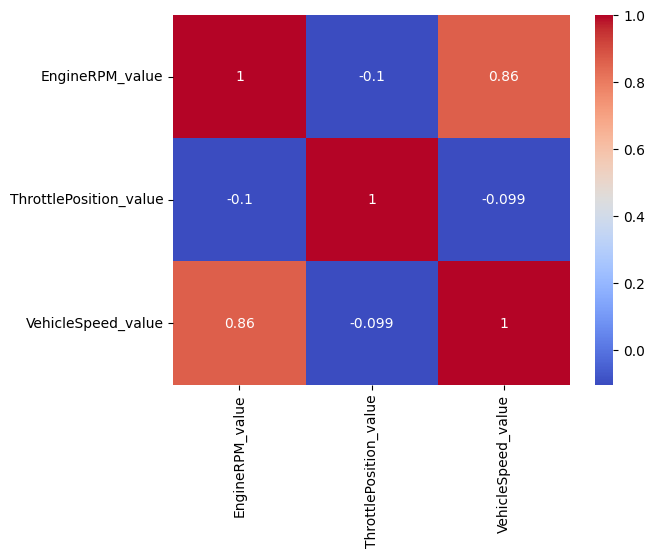

In [7]:
try:
    import seaborn as sns
except ImportError as err:
    !pip install seaborn
    import seaborn as sns

# Correlación entre las variables
data_corr = df_ml.corr(numeric_only=True)

sns.heatmap(data_corr, annot=True, cmap='coolwarm')
plt.show()

Las figuras anteriores muestran información que se corresponden con la realidad de la naturaleza de los datos obtenidos. La mayoría de los datos de la revoluciones se concentran en el ralentí del vehículo y en el rango de operación normal de un motor diesel, entre las 1500 y 2000. Dentro de la velocidad, la mayor parte de los datos se concentran el el vehículo parado, el rango 40-80km/h ya que representan los límites de velocidad generales en la mayoría del territorio y valores alrededor de 120km/h en autopista. 

En la matriz de correlación se observa como las revoluciones del motor y la velocidad muestran una clara dependiencia, mientras que la velocidad con la posición del acelerador no. Esto se puede deber a como la marcha en la que se encuentra el vehículo puede modificar la velocidad independientemente de la posición del acelerador, o incluso a las características de la ruta que ha seguido el vehículo.

# 3. Desarrollo de los modelos

Para el entrenamiento de los modelos se utilizará la librería scikit-learn, una librería de aprendizaje automático para Python. Los principales motivos para la utilización de esta librería son la familiaridad con la misma, ya que se ha utilizado en asignaturas del máster, además de su amplia documentación y ejemplos.

Para este ejemplo se pretende obtener un modelo de clasificación, donde se indique si una medición representa una conducción temeraria o no. En principio los datos no se encuentran etiquetados, por lo que se debería utilizar un modelo de aprendizaje no supervisado, sin embargo, sí es posible definir lo que se considera conducción temeraria y etiquetar los datos disponibles. Por tanto, se realizará el entreno con un modelo supervisado y uno no supervisado, comparando los resultados entre ambos.

Para la elección del modelo dentro de la propia documentación de la librería se muestra un [diagrama](https://scikit-learn.org/stable/machine_learning_map.html) que se puede utilizar como guía. Siguiendo esta guía se utilizará un modelo K-means como no supervisado y un modelo SVC Lineal como supervisado.

## 3.1 Aprendizaje no supervisado - k-means

El algoritmo KMeans agrupa los datos intentando separar las muestras en 'n' grupos de igual varianza, minimizando un criterio conocido como inercia o la suma de cuadrados dentro del clúster. Este algoritmo requiere que se especifique el número de clústers. Se adapta bien al número de muestras y es utilizado en un amplio número de campos diferentes.

A pesar de que la intución del usuario indica que tan solo deberían existir dos cluster, como es conducción temeraria o no, existe un método dentro del propio modelo utilizado para calcular el número óptimo de estos. Para esto se utiliza el conocido como "Método del codo", donde se grafica el valor del WCSS frente a los diferentes números de clusters. Identificando el codo dentro del gráfico se puede obtener el valor óptimo. El WCSS representa cuán similares son los datos dentro del mismo clúster, indicando la distancia de estos respecto al centro.

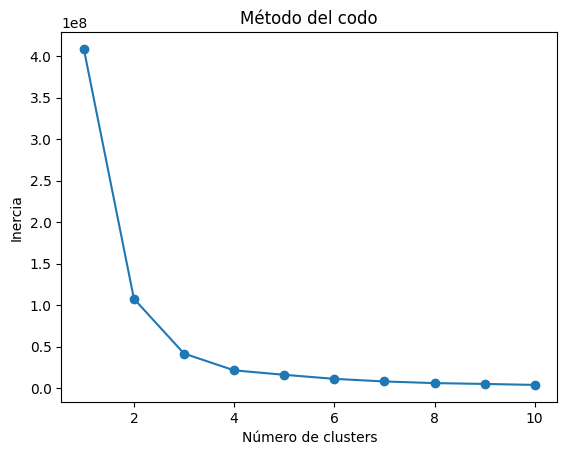

In [8]:
SEED = 1234

from sklearn.cluster import KMeans

# Método del codo
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,random_state=SEED)
    kmeans.fit(df_ml)
    inertias.append(kmeans.inertia_)

# Gráfica
plt.plot(range(1,11), inertias, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

Se observa como el codo del gráfico se coloca en k=4, siendo este el número ideal de clusters. Se utiliza a partir de ahora este modelo como óptimo.

In [9]:
kmeans_opt = KMeans(n_clusters=4, random_state=SEED)

# Obtención de los grupos
y = kmeans_opt.fit_predict(df_ml)

# Etiquetado del conjunto de datos
df_ml['cluster'] = y

Una vez obtenidos los grupos es posible obtener los centroides de los mismos, de forma que se pueda intentar interpretar el sentido que estos toman.

In [10]:
# Centroides de los grupos
for i in range(4):
    print("Grupo " + str(i) + " -> RPM : " + str(kmeans_opt.cluster_centers_[i,0]) + " | % Pedal: " +  str(kmeans_opt.cluster_centers_[i,1]) + " | Velocidad: " +  str(kmeans_opt.cluster_centers_[i,2]))

Grupo 0 -> RPM : 2023.0249999999992 | % Pedal: 94.736052 | Velocidad: 64.73214285714283
Grupo 1 -> RPM : 817.3474576271174 | % Pedal: 95.38239593220338 | Velocidad: 3.629943502824773
Grupo 2 -> RPM : 1594.113074204947 | % Pedal: 95.48056706713781 | Velocidad: 51.94346289752652
Grupo 3 -> RPM : 2659.9537037037026 | % Pedal: 93.42122666666667 | Velocidad: 90.37962962962963


Los 4 grupos resultantes pueden tomar el siguiente sentido:

- Grupo 0: Representa el vehículo circulando en entornos interurbanos e incluso autovías. Tanto las revoluciones del motor como la velocidad moderadamente elevadas.
- Grupo 1: Representa el vehículo en ralentí o arrancando. Velocidades y revoluciones por minuto muy bajas junto con el pedal del acelerador sin pisar.
- Grupo 2: Representa la conducción el vehículo en entornos urbanos. El pedal del acelerador se encuentra ligeramente pulsado, la velocidad ronda los 50km/h y el rango de revoluciones se correspondería con la circulación urbana en 3ª marcha.
- Grupo 3: Este grupo puede representar los posibles patrones temerarios que se están intentando detectar. Las revoluciones del motor son bastante elevadas, además de la velocidad y la posición del acelerador.

Se puede ahora dividir el conjunto de datos en los distintos grupos que se han obtenido, con finalidades tanto de análisis como de observación posterior en los distintos gráficos

In [11]:
# Separación de los datos
group0 = df_ml[df_ml.cluster == 0]
group1 = df_ml[df_ml.cluster == 1]
group2 = df_ml[df_ml.cluster == 2]
group3 = df_ml[df_ml.cluster == 3]

# Observación de los datos del grupo 3
print(group3.iloc[50:60])

     EngineRPM_value  ThrottlePosition_value  VehicleSpeed_value  cluster
747           2526.0                56.07888               128.0        3
748           2522.0                95.68704               126.0        3
749           2476.0                95.68704               125.0        3
750           2459.0                95.68704               122.0        3
751           2366.0                95.68704               122.0        3
753           2508.0                89.02032               107.0        3
778           2688.0                87.05952                64.0        3
779           2780.0                95.68704                65.0        3
784           2483.0                95.68704                41.0        3
787           2975.0                95.68704                76.0        3


La observación de los datos del grupo 3 confirman la idea que se podía intuir con la información de los centroides. La posición del acelerador, las revoluciones del motor o la velocidad se pueden considerar temerarias dependiendo del umbral que se quiera aplicar.

Se puede mostrar finalmente en una gráfica 3D la distribución de las distintas mediciones y el grupo al cual se ha asignado.

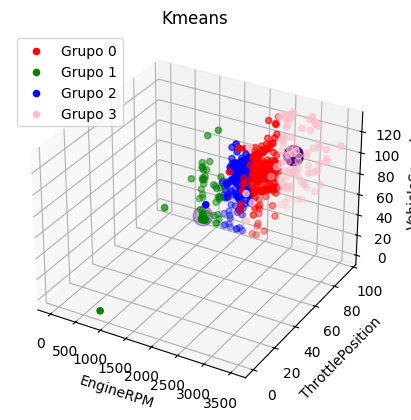

In [12]:
kplot = plt.axes(projection='3d')

# Creación de los puntos de los grupos
kplot.scatter3D(group0.EngineRPM_value, group0.ThrottlePosition_value, group0.VehicleSpeed_value, c='red', label='Grupo 0')
kplot.scatter3D(group1.EngineRPM_value, group1.ThrottlePosition_value, group1.VehicleSpeed_value, c='green', label='Grupo 1')
kplot.scatter3D(group2.EngineRPM_value, group2.ThrottlePosition_value, group2.VehicleSpeed_value, c='blue', label='Grupo 2')
kplot.scatter3D(group3.EngineRPM_value, group3.ThrottlePosition_value, group3.VehicleSpeed_value, c='pink', label='Grupo 3')

# Creación de los centroides
kplot.scatter3D(kmeans_opt.cluster_centers_[:,0], kmeans_opt.cluster_centers_[:,1], kmeans_opt.cluster_centers_[:,2], color = 'indigo', s = 200)

# Creación de la gráfica
plt.legend()
plt.title("Kmeans")
kplot.set_xlabel("EngineRPM")
kplot.set_ylabel("ThrottlePosition")
kplot.set_zlabel("VehicleSpeed")
plt.show()

In [13]:
# Antes de continuar con el próximo modelo se elimina la columna creada por el anterior.

df_ml = df_ml.drop('cluster', axis=1)

# 3.2 Aprendizaje supervisado - LinearSVC

Las máquinas de soporte vectorial representan un algoritmo de aprendizaje automático supervisado donde se clasifican los valores encontrando un hiperplano óptimo que separa las distintas clases de datos. Puede ser utilizado para tareas tanto de clasificación como de regresión. Es un algoritmo eficiente en términos de memoria, además de funcionar adecuadamente en problemas donde el número de dimensiones supera el número de muestras.

Como para este modelo es necesario disponer de datos etiquetados se debe decidir qué se considera conducción temeraria. Se pueden establecer distintos umbrales dependiendo del tipo de medición realizada:

- EngineRPM: El vehículo que se ha utilizado para obtener los datos cuenta con un motor diesel, por lo que el rango de revoluciones óptimas de este es menor que en un motor gasolina. Por tanto, se considera que cualquier valor fuera del rango comprendido entre el ralentí del mismo (alrededor de 790 rpm) y 2600 rpm puede resultar perjudicial para el rendimiento.
- ThrottlePosition: Por norma general, no es buena práctica llegar al fondo del acelerador durante la conducción del vehículo. Para este caso en concreto se establece el 10% final como umbral.
- VehicleSpeed: De acuerdo con la legislación vigente en España, la velocidad máxima absoluta que se puede alcanzar legalmente son 120 km/h, por tanto, se considera cualquier velocidad superior como temeraria. No se disponen de datos de posicionamiento GPS, lo que se podría utilizar para detectar si el usuario supera la velocidad máxima de la vía.

Se crea por tanto una función que etiqueta los datos en base a las condiciones establecidas anteriormente y se añade al conjunto de datos.

In [14]:
# Función de etiquetado
def evaluation(row):
    if row['EngineRPM_value'] >= 2600 or row['EngineRPM_value'] <= 790:
        val = 1
    elif row['VehicleSpeed_value'] > 120:
        val = 1
    elif row['ThrottlePosition_value'] < 10:
        val = 1
    else:
        val = 0
    return val

# Se aplica la función al conjunto de datos, añadiendo la nueva columna
df_ml['reckless'] = df_ml.apply(evaluation, axis=1)
print(df_ml.head())

   EngineRPM_value  ThrottlePosition_value  VehicleSpeed_value  reckless
0            851.0                95.68704                 0.0         0
1           1077.0                95.68704                 0.0         0
2           1829.0                95.68704                 0.0         0
3           1910.0                95.68704                 0.0         0
4            845.0                95.68704                 0.0         0


Se observa como se han etiquetado 78 mediciones como temerarias. Este número es ligeramente menor al obtenido por el modelo entrenado en el apartado anterior.

In [15]:
df_ml[df_ml.reckless == 1].count()

EngineRPM_value           78
ThrottlePosition_value    78
VehicleSpeed_value        78
reckless                  78
dtype: int64

Dentro del aprendizaje supervisado el primer paso consiste en la división del conjunto de datos, de forma que se puedan obtener resultados del funcionamiento del modelo con datos con los que no se ha entrenado. Para esto la propia librería scikit-learn dispone de una función encargada de esta tarea, de forma que se asegura que existe el número suficientes de etiquetas de cada tipo para el correcto entrenamiento del modelo.

In [16]:
from sklearn.model_selection import train_test_split

# Separación de las características y la etiqueta
X = df_ml.iloc[:,:-1]
y = df_ml.iloc[:,-1]

# División del conjunto
# Se reserva un 30% del conjunto para la realización de los test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

Otro punto importante dentro de este modelo es la optimización de los hiperparámetros, es decir, los parámetros que controlan el funcionamiento del modelo. La utilización de los valores óptimos mejora el funcionamiento del modelo en datos nuevos. Dentro de la librería existen dos formas de buscar el valor óptimo para estos parámetros, como son una búsqueda aleatoria y una búsqueda por rejillas. 

Ambas búsquedas exploran exactamente el mismo espacio de parámetros, sin embargo, la búsqueda aleatoria ofrece unos resultados ligeramente peores a cambio de reducir el tiempo de búsqueda. Para este caso en concreto, se utiliza la búsqueda por rejilla ya que el tiempo de entrenamiento y comprobación de los valores es reducido, además del número de hiperparámetros.

Para el modelo utilizado los hiperparámetros más relevantes incluyen el parámetro de normalización (C), que controla el equilibrio entre lograr un error bajo en los datos de entrenamiento y la minimización de los pesos; la función de pérdida (loss), que puede ser _hinge_ o _squared\_hinge_; y el tipo de penalización, que determina la normal utilizada en la penalización (l1 o l2).

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Hiperparámetros a probar
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}

# Búsqueda de rejilla
grid_search = GridSearchCV(estimator=LinearSVC(random_state=SEED,
                                               max_iter=10000),
                                               param_grid=param_grid,
                                               cv=5,
                                               scoring='accuracy')
grid_search.fit(X_train, y_train)

# Muestra del mejor resultado
print(f"Mejor puntuación: {grid_search.best_score_:.3f}")
print(f"Mejores parámetros: {grid_search.best_params_}")

/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Libline

Mejor puntuación: 0.953
Mejores parámetros: {'C': 0.001, 'loss': 'hinge', 'penalty': 'l2'}


/home/martin/udc/muiot/q3_aprendizaje_automatico/MIOT_ML/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Se obtienen de esta forma los hiperparámetros óptimos para este modelo, además de la puntuación en el conjunto de entrenamiento. Se pueden obtener las métricas de este modelo correspondiente al conjunto de test.

In [18]:
svm_opt = grid_search.best_estimator_
accuracy = svm_opt.score(X_test, y_test)

print(f"Puntuación en el conjunto de test: {accuracy:.3f}")

Puntuación en el conjunto de test: 0.968


Para este conjunto de datos en concreto el conjunto de test obtiene un mejor resultado que el conjunto de entrenamiento. Es posible conocer también la distribución de los fallos mediante una matriz de confusión.

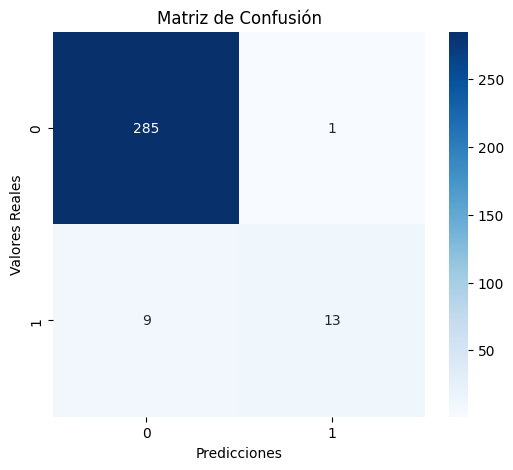

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Matriz de confusión
y_test_conf_matrix = y_test.to_numpy()
y_pred_conf_matrix = svm_opt.predict(X_test)

cm = confusion_matrix(y_test_conf_matrix, y_pred_conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_conf_matrix), 
            yticklabels=np.unique(y_test_conf_matrix))
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Se observa en la matriz como la mayoría de los errores se producen cuando el modelo detecta como normales valores que se han considerado como conducciones temerarias.

# 4. Comparación de los modelos y puntuación del usuario

En este apartado se comprueba el funcionamiento de ambos modelos con un subconjunto de los datos, comparando los resultados obtenidos por cada uno. Se comparan además las puntuaciones que cada uno otorgaría al usuario, además de la puntuación calculada manualmente.

Para esta tarea se parte del conjunto de test creado anteriormente, ya que para el modelo no supervisado no supone ninguna diferencia mientras que para el modelo supervisado sirve como certeza de que las instancias a evaluar no se han utilizado durante su entrenamiento.

In [21]:
# Creación del conjunto de datos
df_comp = X_test.copy()
df_comp['manual_eval'] = y_test

# Creación de la columna con las predicciones del modelo no supervisado
kmeans_eval = []
test_var = kmeans_opt.predict(X_test)
for el in test_var:
    if el == 3:
        kmeans_eval.append(1)
    else:
        kmeans_eval.append(0)
df_comp['kmeans_eval'] = kmeans_eval

# Creación de la columna con las predicciones del modelo no supervisado
df_comp['svm_eval'] = svm_opt.predict(X_test)

# Conjunto de datos completo
print(df_comp)

     EngineRPM_value  ThrottlePosition_value  VehicleSpeed_value  manual_eval  \
836           2261.0                88.62816                67.0            0   
523            800.0                95.68704                 0.0            0   
89             795.0                95.68704                 0.0            0   
915           1731.0                95.68704                45.0            0   
270           1659.0                95.68704                69.0            0   
..               ...                     ...                 ...          ...   
499            803.0                95.68704                 0.0            0   
44             818.0                95.68704                 0.0            0   
967           1476.0                95.68704                57.0            0   
504            802.0                95.68704                 0.0            0   
187           1977.0                95.68704                82.0            0   

     kmeans_eval  svm_eval 

Una vez obtenidas las predicciones de ambos modelos es posible comparar las diferencias entre la columna establecida manualmente y las establecidas por los modelos. Se pueden también comparar las distintas puntuaciones otorgadas por cada uno.

In [22]:
# Discrepancias entre la evaluación manual y la obtenida mediante el modelo no supervisado
print(df_comp[df_comp.manual_eval != df_comp.kmeans_eval].iloc[:, df_comp.columns != 'svm_eval'].head())

# Discrepancias entre la evaluación manual y la obtenida mediante el modelo supervisado
print(df_comp[df_comp.manual_eval != df_comp.svm_eval].iloc[:, df_comp.columns != 'kmeans_eval'].head())

     EngineRPM_value  ThrottlePosition_value  VehicleSpeed_value  manual_eval  \
446            839.0                 0.00000                 0.0            1   
386           2431.0                58.82400                55.0            0   
904           2360.0                95.68704                62.0            0   
719           2455.0                95.68704                86.0            0   
681            787.0                95.68704                 0.0            1   

     kmeans_eval  
446            0  
386            1  
904            1  
719            1  
681            0  
     EngineRPM_value  ThrottlePosition_value  VehicleSpeed_value  manual_eval  \
801           2720.0                95.68704                77.0            1   
738           2418.0                95.68704               125.0            1   
386           2431.0                58.82400                55.0            0   
681            787.0                95.68704                 0.0           

In [23]:
total_values = df_comp.shape[0]

# Puntuación asignada de forma manual
manual_values = df_comp['manual_eval'].value_counts()
manual_score = manual_values[0] / total_values * 100
print("Puntuación asignada de forma manual: {:.2f}%".format(manual_score))

# Puntuación asignada por el modelo no supervisado
kmeans_values = df_comp['kmeans_eval'].value_counts()
kmeans_score = kmeans_values[0] / total_values * 100
print("Puntuación asignada por el modelo no supervisado: {:.2f}%".format(kmeans_score))

# Puntuación asignada por el modelo supervisado
svm_values = df_comp['svm_eval'].value_counts()
svm_score = svm_values[0] / total_values * 100
print("Puntuación asignada por el modelo supervisado: {:.2f}%".format(svm_score))

Puntuación asignada de forma manual: 92.86%
Puntuación asignada por el modelo no supervisado: 91.88%
Puntuación asignada por el modelo supervisado: 95.45%


Se puede observar como la puntuación obtenida por el modelo no supervisado es bastante similar a la establecida de forma manual, mientras que el modelo supervisado ofrece una puntuación ligeramente superior. El funcionamiento del modelo no supervisado parece bastante adecuado, como se puede observar en las celdas anteriores, ya que observando detenidamente las mediciones que este ha marcado como temerarias pero no han sido marcadas manualmente sí que podrían tomarse como temerarias o por lo menos indicativo de ello, a pesar de que no cumplen estrictamente con las condiciones. Parece que este modelo sí es capaz de comprender el concepto de temerario y detectarlo dentro del conjunto de datos, mientras que este comportamiento no se repite en el modelo supervisado.